# Pixelklassifizierung mit Scikit-learn
Pixelklassifizierung ist eine Technik zur Zuordnung von Pixeln zu verschiedenen Klassen. Bei zwei Klassen (Objekt und Hintergrund) sprechen wir von Binarisierung. In diesem Beispiel verwenden wir einen [Random Forest Classifier](https://en.wikipedia.org/wiki/Random_forest) für die Pixelklassifizierung.

Siehe auch
* [Scikit-learn Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Klassifizierung von Landbedeckung von Chris Holden](https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html)

In [1]:
from sklearn.ensemble import RandomForestClassifier

from skimage.io import imread, imshow
import numpy as np
import napari

Als Beispielbild verwenden wir den Bilddatensatz [BBBC038v1](https://bbbc.broadinstitute.org/bbbc/BBBC038), der von der Broad Bioimage Benchmark Collection verfügbar ist [Caicedo et al., Nature Methods, 2019](https://doi.org/10.1038/s41592-019-0612-7).

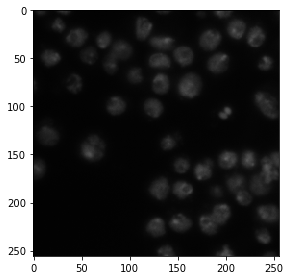

In [2]:
image = imread('../../data/BBBC038/0bf4b1.tif')

imshow(image)

Um zu demonstrieren, wie der Algorithmus funktioniert, annotieren wir zwei kleine Bereiche auf der linken Seite des Bildes mit den Werten 1 und 2 für Hintergrund und Vordergrund (Objekte).

/Users/haase/opt/anaconda3/envs/bio_39/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
/Users/haase/opt/anaconda3/envs/bio_39/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


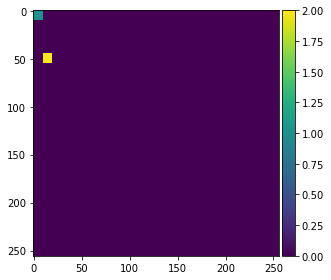

In [3]:
annotation = np.zeros(image.shape)
annotation[0:10,0:10] = 1
annotation[45:55,10:20] = 2

imshow(annotation, vmin=0, vmax=2)

## Generierung eines Feature-Stacks
Pixelklassifikatoren wie der Random Forest Classifier nehmen mehrere Bilder als Eingabe. Wir nennen diese Bilder typischerweise einen Feature-Stack, da für jedes Pixel nun mehrere Werte (Features) existieren. Im folgenden Beispiel erstellen wir einen Feature-Stack mit drei Merkmalen:
* Der ursprüngliche Pixelwert
* Der Pixelwert nach einer Gaußschen Unschärfe
* Der Pixelwert des Gaußsch geglätteten Bildes, verarbeitet durch einen Sobel-Operator.

Somit entrauschen wir das Bild und erkennen Kanten. Alle drei Bilder dienen dem Pixelklassifikator dazu, positive und negative Pixel zu unterscheiden.

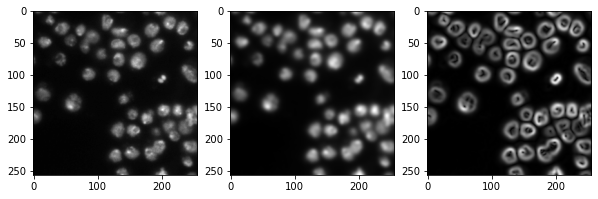

In [4]:
from skimage import filters

def generate_feature_stack(image):
    # determine features
    blurred = filters.gaussian(image, sigma=2)
    edges = filters.sobel(blurred)

    # collect features in a stack
    # The ravel() function turns a nD image into a 1-D image.
    # We need to use it because scikit-learn expects values in a 1-D format here. 
    feature_stack = [
        image.ravel(),
        blurred.ravel(),
        edges.ravel()
    ]
    
    # return stack as numpy-array
    return np.asarray(feature_stack)

feature_stack = generate_feature_stack(image)

# show feature images
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(10,10))

# reshape(image.shape) is the opposite of ravel() here. We just need it for visualization.
axes[0].imshow(feature_stack[0].reshape(image.shape), cmap=plt.cm.gray)
axes[1].imshow(feature_stack[1].reshape(image.shape), cmap=plt.cm.gray)
axes[2].imshow(feature_stack[2].reshape(image.shape), cmap=plt.cm.gray)

## Formatierung der Daten
Wir müssen nun die Eingabedaten so formatieren, dass sie zu dem passen, was scikit-learn erwartet. Scikit-learn erwartet ein Array der Form (n, m) als Eingabedaten und (n) Annotationen. n entspricht der Anzahl der Pixel und m der Anzahl der Features. In unserem Fall ist m = 3.

In [5]:
def format_data(feature_stack, annotation):
    # reformat the data to match what scikit-learn expects
    # transpose the feature stack
    X = feature_stack.T
    # make the annotation 1-dimensional
    y = annotation.ravel()
    
    # remove all pixels from the feature and annotations which have not been annotated
    mask = y > 0
    X = X[mask]
    y = y[mask]

    return X, y

X, y = format_data(feature_stack, annotation)

print("input shape", X.shape)
print("annotation shape", y.shape)

input shape (200, 3)
annotation shape (200,)


## Training des Random Forest Classifiers
Wir trainieren nun den [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), indem wir den Feature-Stack X und die Annotationen y bereitstellen.

In [6]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

## Vorhersage von Pixelklassen
Nachdem der Klassifikator trainiert wurde, können wir ihn verwenden, um Pixelklassen für ganze Bilder vorherzusagen. Beachten Sie im folgenden Code, dass wir `feature_stack.T` bereitstellen, was mehr Pixel sind als X in den obigen Befehlen, da es auch die Pixel enthält, die zuvor nicht annotiert wurden.

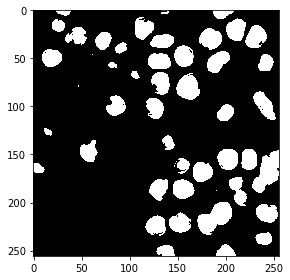

In [7]:
res = classifier.predict(feature_stack.T) - 1 # we subtract 1 to make background = 0
imshow(res.reshape(image.shape))

## Interaktive Segmentierung
Wir können auch napari verwenden, um einige Regionen als negativ (Label = 1) und positiv (Label = 2) zu annotieren.

In [8]:
# start napari
viewer = napari.Viewer()

# add image
viewer.add_image(image)

# add an empty labels layer and keet it in a variable
labels = viewer.add_labels(np.zeros(image.shape).astype(int))

/Users/haase/opt/anaconda3/envs/bio_39/lib/python3.9/site-packages/napari_tools_menu/__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


Fahren Sie fort, **nachdem** Sie mindestens zwei Regionen mit den Labels 1 und 2 annotiert haben.

Machen Sie einen Screenshot der Annotation:

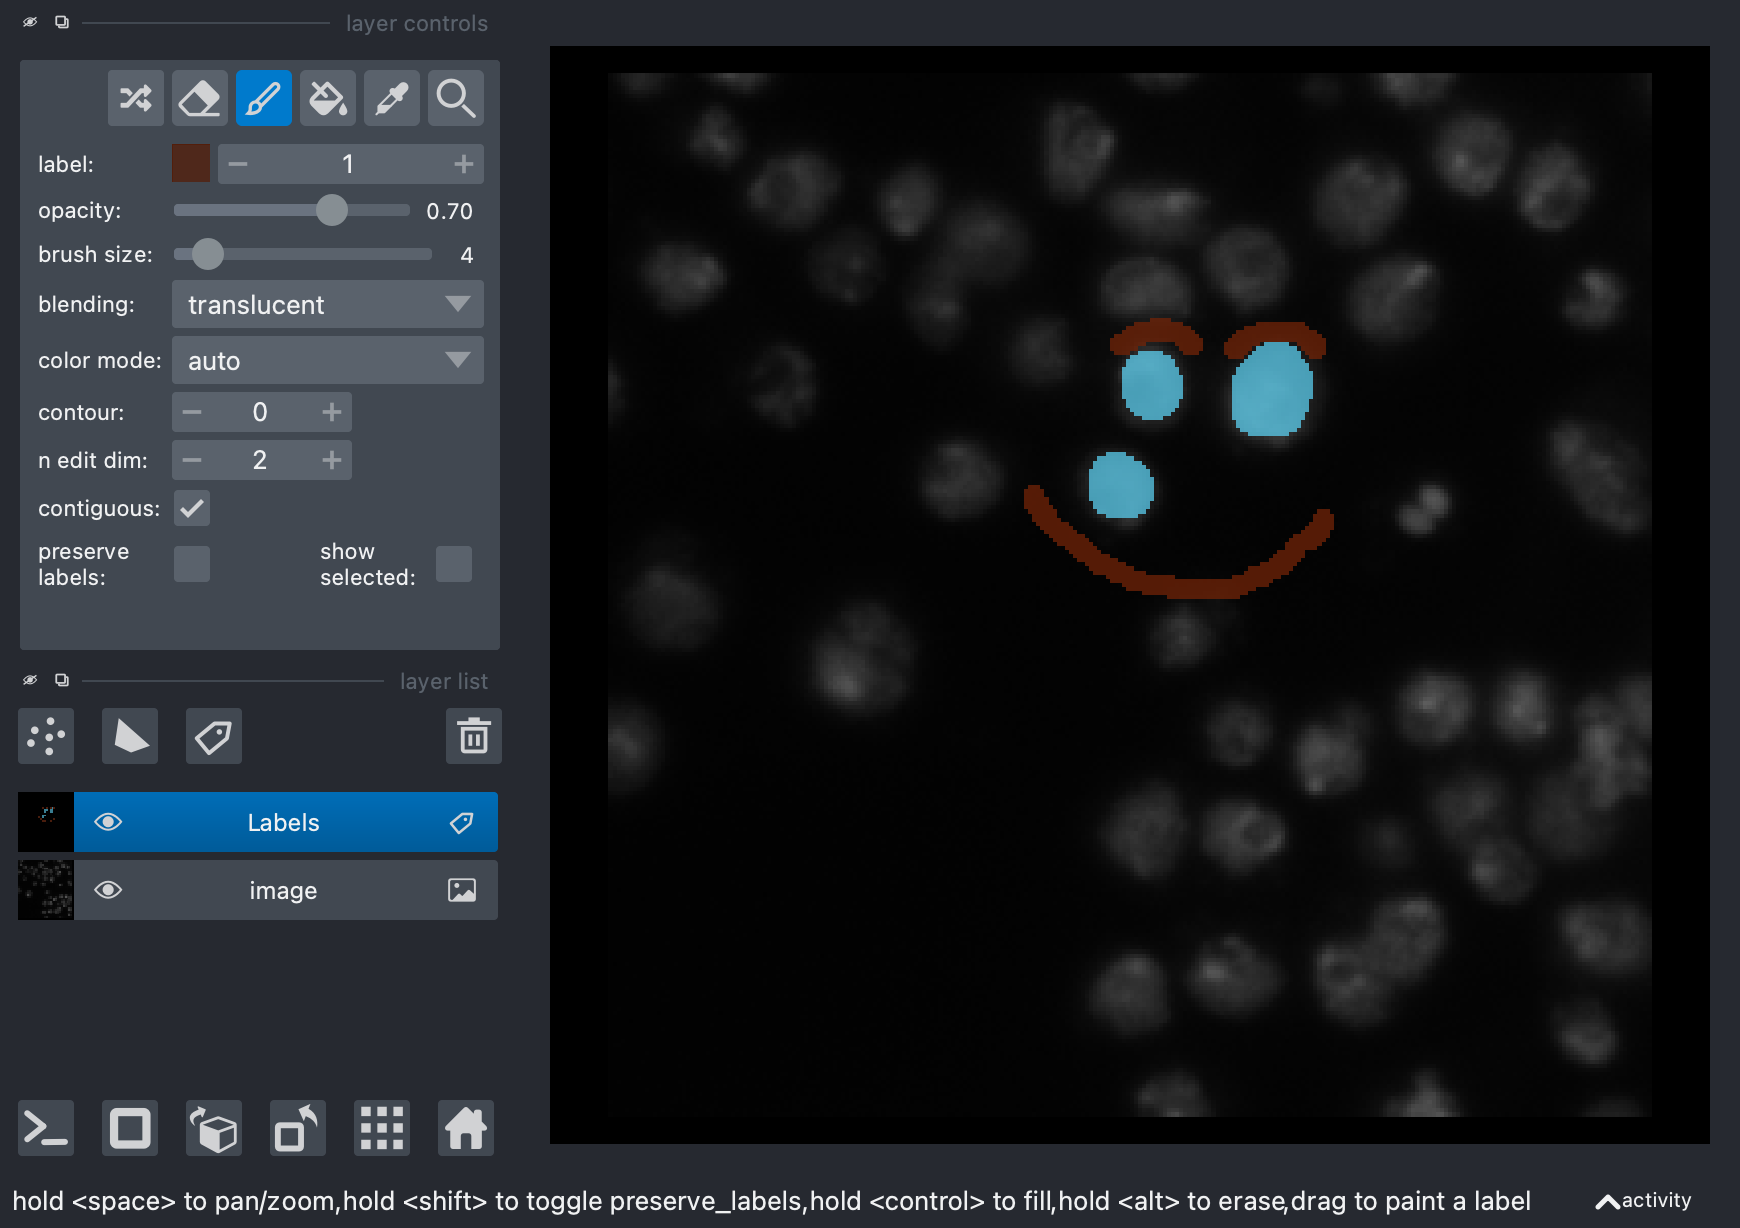

In [9]:
napari.utils.nbscreenshot(viewer)

Rufen Sie die Annotationen aus der napari-Ebene ab:

/Users/haase/opt/anaconda3/envs/bio_39/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


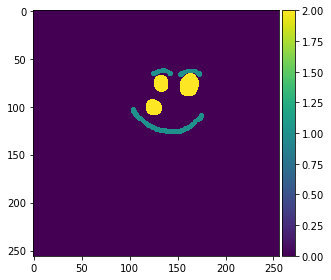

In [10]:
manual_annotations = labels.data

imshow(manual_annotations, vmin=0, vmax=2)

Da wir im obigen Beispiel Funktionen verwendet haben, können wir einfach das gleiche Verfahren mit den manuellen Annotationen wiederholen.

/Users/haase/opt/anaconda3/envs/bio_39/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


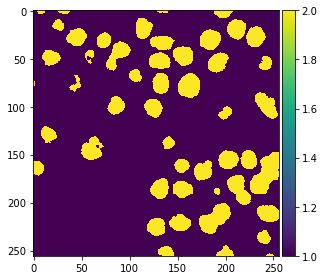

In [11]:
# generate features (that's actually not necessary, 
# as the variable is still there and the image is the same. 
# but we do it for completeness)
feature_stack = generate_feature_stack(image)
X, y = format_data(feature_stack, manual_annotations)

# train classifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X, y)

# process the whole image and show result
result_1d = classifier.predict(feature_stack.T)
result_2d = result_1d.reshape(image.shape)
imshow(result_2d)

Außerdem fügen wir das Ergebnis zu napari hinzu.

In [12]:
viewer.add_labels(result_2d)

<Labels layer 'result_2d' at 0x7f816a1faaf0>

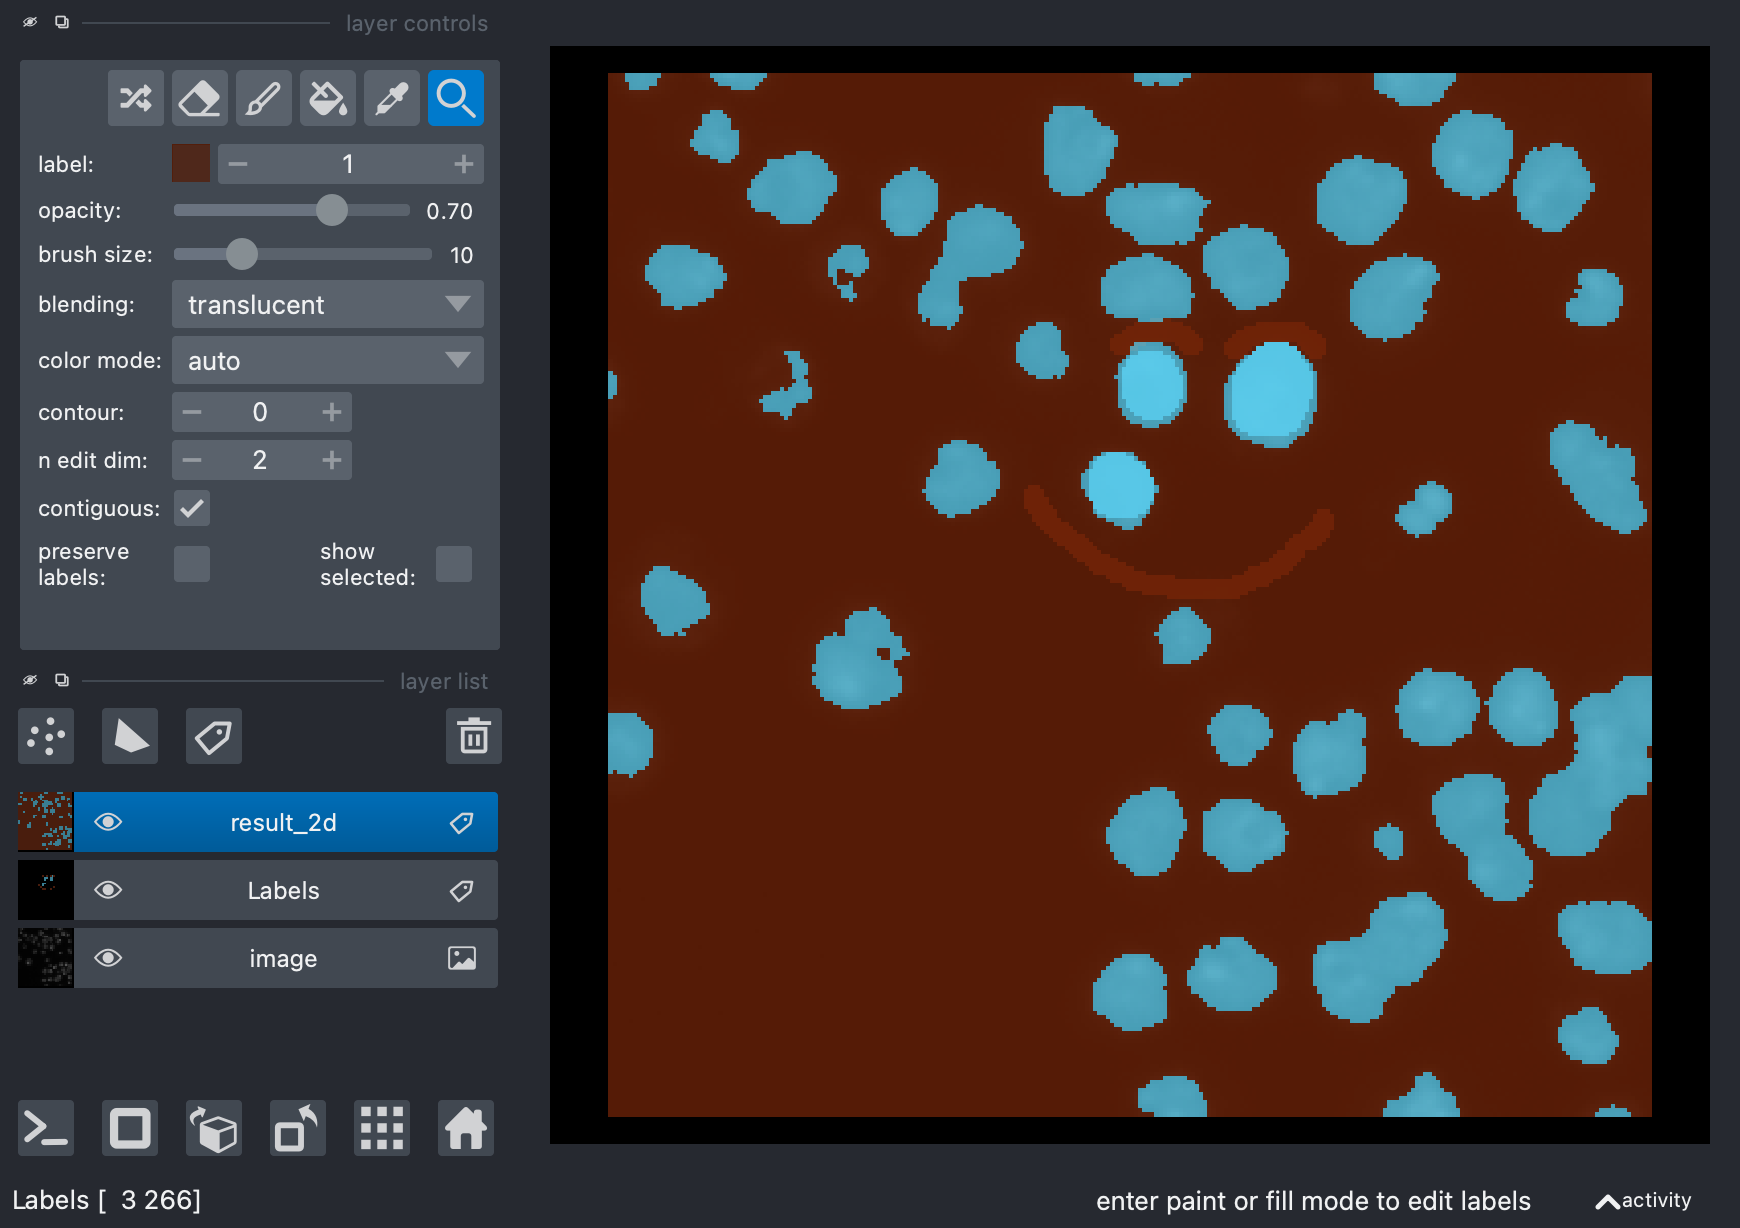

In [13]:
napari.utils.nbscreenshot(viewer)

# Übung
Ändern Sie den Code so, dass Sie drei verschiedene Regionen annotieren können:
* Zellkerne
* Hintergrund
* Die Kanten zwischen Blobs und Hintergrund